In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [4]:
## large ##
# predictive model architecture
layerwidth = 100
nblayers = 1
activation = nn.ReLU()
lat_dim=10


In [5]:
path="Results/Paper/Exp2/Exp2_large2021-02-01-16:43"

In [6]:
MODELS=torch.load(path+"_models.pt",map_location=device)


In [7]:
datasets = ['navalC', 'powerplant', 'protein']
# for key in MODELS.keys():
#     datasets.append(key)

methods=[]#['Ensemble', 'MC dropout', 'MFVI', 'NN-HyVI', 'FuNN-HyVI', 'FuNN-MFVI']
for key in MODELS[datasets[0]][0][1].keys():
    methods.append(key)
    
datasets, methods

(['navalC', 'powerplant', 'protein'],
 ['Ensemble', 'MC dropout', 'MFVI', 'NN-HyVI', 'FuNN-HyVI', 'FuNN-MFVI'])

# Results on Test

In [8]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [9]:
results=[]

#torch.cat([model(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=0)
for dataset in datasets:   

    for split in MODELS[dataset][:5]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=lat_dim).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=lat_dim).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=torch.cat([model(x_, 1000).detach() for x_ in x_test.split(100,dim=0)],dim=1)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

RuntimeError: Error(s) in loading state_dict for HyVI:
	size mismatch for gen.model.0.weight: copying a param with shape torch.Size([20, 5]) from checkpoint, the shape in current model is torch.Size([40, 10]).
	size mismatch for gen.model.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for gen.model.2.weight: copying a param with shape torch.Size([40, 20]) from checkpoint, the shape in current model is torch.Size([80, 40]).
	size mismatch for gen.model.2.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for gen.model.4.weight: copying a param with shape torch.Size([601, 40]) from checkpoint, the shape in current model is torch.Size([601, 80]).

In [42]:
torch.save(results,path+'_results.pt')

# RMSE

In [22]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
#df_.style.highlight_min(axis=1)


,Ensemble,MC dropout,MFVI,NN-HyVI,FuNN-HyVI,FuNN-MFVI
dataset,,,,,,
navalC,0.000439,0.000547,0.000379,0.000220,0.000153,0.000440


In [23]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [24]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & Ensemble & MC dropout &     MFVI &  NN-HyVI & FuNN-HyVI & FuNN-MFVI \\
dataset &          &            &          &          &           &           \\
\midrule
navalC  &  0.0±0.0 &  0.001±0.0 &  0.0±0.0 &  0.0±0.0 &   0.0±0.0 &   0.0±0.0 \\
\bottomrule
\end{tabular}



# LPP

In [25]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,Ensemble,MC dropout,MFVI,NN-HyVI,FuNN-HyVI,FuNN-MFVI
dataset,,,,,,
navalC,6.120915,5.919244,6.482738,7.031494,7.367221,6.326604


In [26]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [48]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &       Ensemble &     MC dropout &          MFVI &       NN-HyVI &     FuNN-HyVI &     FuNN-MFVI \\
dataset    &                &                &               &               &               &               \\
\midrule
navalC     &    6.121±0.121 &     5.92±0.125 &   6.271±0.093 &   6.863±0.055 &   6.953±0.116 &   6.129±0.044 \\
powerplant &  -63.118±4.163 &  -15.918±0.548 &  -2.827±0.011 &  -2.785±0.015 &  -2.782±0.015 &  -2.845±0.015 \\
protein    &  -12.096±0.806 &   -20.019±0.59 &  -2.864±0.006 &   -2.85±0.004 &  -2.841±0.006 &  -2.888±0.005 \\
\bottomrule
\end{tabular}



# displaying logs

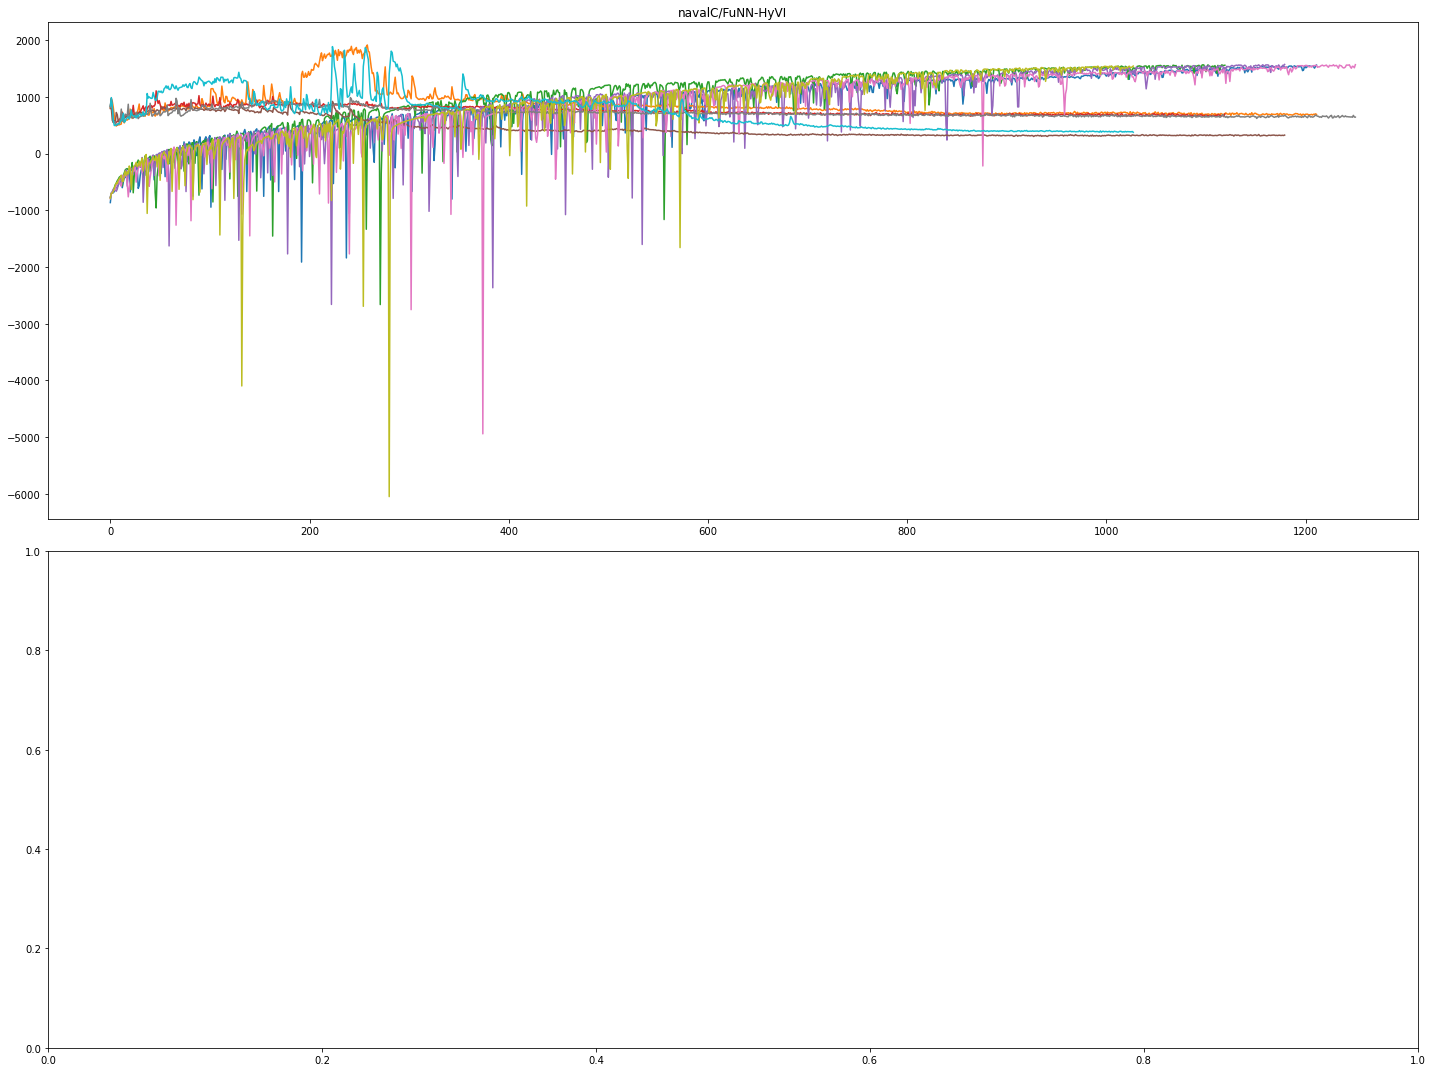

In [29]:
from pylab import *
methods_=['FuNN-HyVI']
fig, ax=plt.subplots(len(methods_)+1, len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods_:
    for dataset in datasets:
        for split in MODELS[dataset][:5]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

In [9]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

VARs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(100,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=50000)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=lat_dim).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=lat_dim).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        torch.save(VARs,path+'_epist_VAR_50k.pt')

navalC
0
1
2
3
4


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=VARs
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}

fpr=torch.arange(50000).true_divide(50000)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

navalC/Ensemble: 0.9999969753645047
navalC/MC dropout: 0.999996239651416
navalC/MFVI: 0.749596258756494
navalC/NN-HyVI: 0.9999999886039885
navalC/FuNN-HyVI: 0.9999781659125189
navalC/FuNN-MFVI: 0.9891658940841295


In [13]:
torch.save(roc_data,path+'_roc_data_VAR50k.pt')
torch.save(AUC,path+'_AUC_VAR50k.pt')


In [52]:
roc_data=torch.load(path+'_roc_data_VAR50k.pt')
AUC=torch.load(path+'_AUC_VAR50k.pt')


<ipython-input-13-ab5aff74b4cc>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


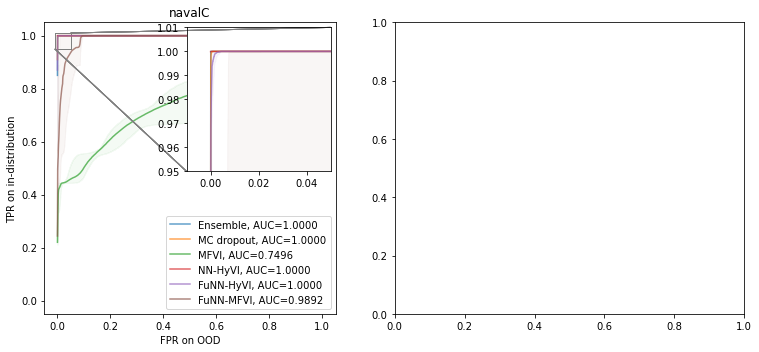

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=len(datasets)+1
fig, ax= plt.subplots(1,l,figsize=(5*l+1,5))
d=0
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.05]#, 0.2, 0.05]
B=[0.95]#,0.8, 0.95]

fpr=torch.arange(50000).true_divide(50000)
colors=[]
for dataset in datasets:
    c=0
    if not dataset=='yacht':
        zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right')      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=roc_data[dataset][method]['tpr_mean']
        tpr_min=roc_data[dataset][method]['tpr_min']
        tpr_max=roc_data[dataset][method]['tpr_max']
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.05, color=cmap(c))
        #custom_text.append(method+' (AUC:{})'.format(np.mean(AUCs).round(3)))
    #lgd = ax[d].legend(custom_lines, custom_text, loc='best')

  #'upper right')#width="40%", height="40%",
        if not dataset=='yacht':
            zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
            zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.05, color=cmap(c))  
            mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()

In [ ]:
plt.savefig(path+"ROC_curves_VAR_50K.pdf", dpi=600)


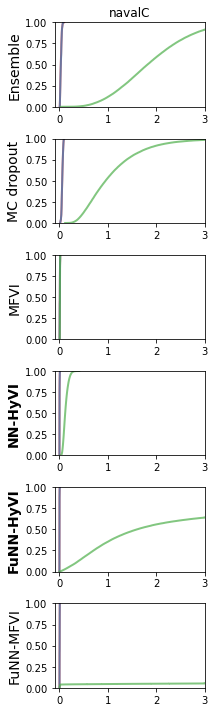

In [28]:
from pylab import *
import seaborn as sns
import pandas as pd

parameters = {'axes.labelsize':14,
              'axes.titlesize': 12,
              'xtick.labelsize' : 10,
              'ytick.labelsize' : 10,
              'figure.titlesize':14}
plt.rcParams.update(parameters)
Hs=VARs
n_datasets=len(datasets)
n_methods=len(methods)
fig,ax=plt.subplots(n_methods,n_datasets,figsize=(3*n_datasets,10),squeeze=False)

data_type=['train','test','OOD']
method_names=['MC dropout','Ensemble','MFVI','FuNN-MFVI','NN-HyVI','FuNN-HyVI']

label=['train', 'test', 'OOD']
split=1
cmap=plt.get_cmap('Set1')
d=0
for dataset in datasets:
    m=0
    ax[m,d].set_title(dataset)
    for method in methods:
        H=Hs[dataset][method][split]
        #for i in range(len(H)):
        #data=pd.DataFrame([pd.DataFrame(H[i].cpu(), columns=[data_type[i]]) for i in range(3)], columns=['type'])
        #print(data)
        #print(data)
 #       data=pd.concat([pd.Series(H[0].cpu(),name='train'),pd.Series(H[1].cpu(),name='test'),pd.Series(H[2].cpu(),name='OOD')], axis=0, join='inner')
#        print(data)
        for i in range(len(H)):
            #sns.histplot(H[i].cpu(), stat='probability', element='step', alpha = .7, kde=True, color=cmap(i), label=data_type[i],ax=ax[m,d])#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
            sns.ecdfplot(H[i].cpu(),color=cmap(i), label=data_type[i],ax=ax[m,d],lw=2, alpha=.7)#, color=colors[i])#, hist=False, norm_hist=True)#color=colors[i],
        ax[m,d].set_xlim(left=-.1, right=3)
        if (m,d) == (3,2): 
            ax[m,d].legend()#.remove()
        ax[m,d].set_ylabel('')
        if d ==0:
            if method=='FuNN-HyVI' or method== 'NN-HyVI' or method== 'FuNN-HyVI*':
                ax[m,d].set_ylabel(method, {'fontweight':'bold'})
            else:
                ax[m,d].set_ylabel(method)
        m+=1

    d+=1
#ax[3,2].legend(loc='upper right', prop={'size': 8})#bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()
fig.align_ylabels(ax[:, 0])
plt.savefig(path+"_PredictiveEntropy_Exp2-{}.pdf".format(split), dpi=600)
#plt.subplots_adjust(top=.9)
#plt.suptitle('Posterior Predictive Entropy Distributions')
plt.show()

In [ ]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

#Hs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

def nn_dist(X):
    #X_in=torch.cat([X[0],X[1]])
    X_train=X[0]
    X_test=X[1]
    X_ood=X[2]
    dist_ood=torch.cdist(X_train,X_ood)
    dist_test=torch.cdist(X_train,X_test)
    #print(X_in.shape, X_ood.shape, dist.shape)
    return dist_test.min(dim=0)[0], dist_ood.min(dim=0)[0]

fig, ax=plt.subplots(3, figsize=(5,10))
i=0
for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=50000)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        if split_nb<2:
            test, ood= nn_dist(X)
            sns.histplot(test.cpu(), stat='probability', ax=ax[i], label='test', color='red')
            sns.histplot(ood.cpu(), stat='probability', ax=ax[i], label='OOD', color='green')
            ax[i].set_title(dataset)
            ax[i].legend()
            i+=1

fig.tight_layout()

# Entropy parametric vs predictor


In [39]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)



In [40]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{} for dataset in datasets}

def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

nb_predictors=1000    
n_MC=200
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    Hs[dataset].update({(method,'parameter'):[] for method in methods})
    Hs[dataset].update({(method,'predictor'):[] for method in methods})

    for split in MODELS[dataset][:5]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.get_parameters, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(model, OOD_sampler, n=100, n_MC=200))

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
      #  Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
#        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model.predict(x,nb_predictors), OOD_sampler, n=100, n_MC=200))
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=10).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=10).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
#         torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')

navalC
0
1
2
3
4


In [41]:
torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')
Hs=torch.load(path+'_ParamVsPredictor_entropy.pt')
#Hs

In [43]:
import pandas as pd

H_mean={} 
H_std={}
for dataset, value in Hs.items():
    print(dataset)
    H_mean.update({dataset:{}})
    H_std.update({dataset:{}})
    for key2, results in value.items():
        H_mean[dataset].update({key2:np.mean(results)})
        H_std[dataset].update({key2:np.std(results)})

navalC


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
methods=['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
index=pd.MultiIndex.from_product([methods,["parameter"]])
pd.DataFrame(H_mean, index=index).transpose().style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter
navalC,nan,644.188184,-142.739795,-1218.168701,1108.015430,-19754.131250


In [45]:
index=pd.MultiIndex.from_product([methods,["predictor"]])
pd.DataFrame(H_mean, index=index).transpose().style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor
navalC,-167.723860,-70.716210,-3959.137188,272.555126,-796.053895,-913.347056
